In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline


from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
#Load the data
df = pd.read_csv("/content/drive/MyDrive/My_Projects/hospital/delhi_hospital_reviews.csv")
df.head()

,Hospital,Type,Review_Date,Review_Text
0,Safdarjung_Gov,Government,3 weeks ago,“VMMC & Safdarjung Hospital in Delhi is one of...
1,Safdarjung_Gov,Government,2 months ago,I would like to express my sincere appreciatio...
2,Safdarjung_Gov,Government,a month ago,I am writing to express my serious concern reg...
3,Safdarjung_Gov,Government,4 weeks ago,"While there are some good doctors, often only ..."
4,Safdarjung_Gov,Government,a month ago,This was one of the most distressing and disap...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Hospital     300 non-null    object
 1   Type         300 non-null    object
 2   Review_Date  300 non-null    object
 3   Review_Text  299 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB


We have one null value in Review Text let's find out in which is it

In [4]:
df[df.isna().any(axis=1)]

,Hospital,Type,Review_Date,Review_Text
187,Max_Pvt,Private,a month ago,NaN


in Row number 187 we have one Null Value in Review Text let's Change this to "NaN" to "No text"

In [5]:
df['Review_Text'] = df['Review_Text'].fillna("No Text")

We have just changed this now see again is there any null value

In [6]:
df['Review_Text'].isna().sum()

np.int64(0)

In [7]:
df.iloc[187] #No text is visible now

,187
Hospital,Max_Pvt
Type,Private
Review_Date,a month ago
Review_Text,No Text


In [8]:
#2. Function to convert "2 months ago" into a number (0 for recent, 12t for old)
def get_age_months(date):
  date = str(date).lower()
  #Very recent (days/weeks/hours)
  if any(x in date for x in ['hour','day','week']):
    return 0
  #Months
  if 'month' in date:
    number = re.findall(r'\d+', date)
    return int(number[0]) if number else 1 # "a month ago " = 1
  #Years
  if "year" in date:
    number = re.findall(r'\d+', date)
    return int(number[0]) * 12 if number else 12 # "a year ago" = 12
  return 12 #Default

df['Age_months'] = df['Review_Date'].apply(get_age_months)

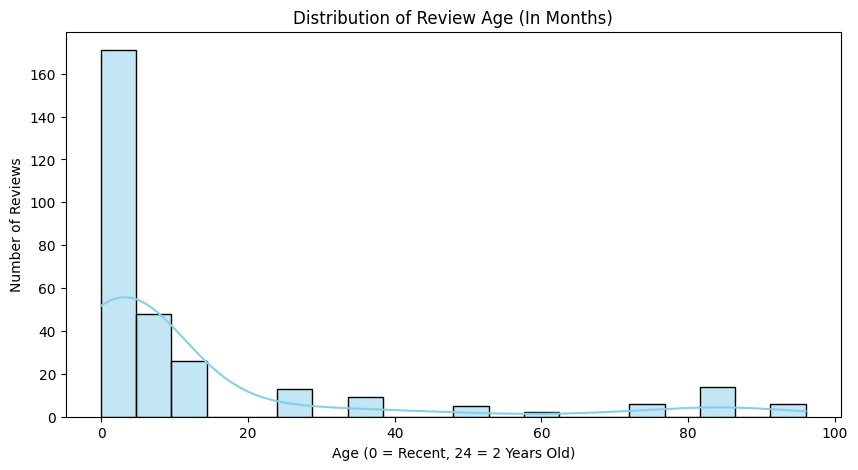

In [9]:
#3. Visualize the distribution of review age
plt.figure(figsize=(10,5))
sns.histplot(df['Age_months'],bins=20, kde=True, color='skyblue')
plt.title("Distribution of Review Age (In Months)")
plt.xlabel("Age (0 = Recent, 24 = 2 Years Old)")
plt.ylabel("Number of Reviews")
plt.show()

In [10]:
#Check the average age per hospital type
print(" --- Average Age of Reviews by Category--- ")
print(df.groupby("Type")['Age_months'].mean().round(1),"months")

 --- Average Age of Reviews by Category--- 
Type
Government    23.8
Private        3.3
Name: Age_months, dtype: float64 months


### 🕒 Data Recency Analysis: Government vs. Private
Before identifying pain points, we analyzed the **average age of reviews** to ensure our insights are relevant to current hospital conditions.

**Key Findings:**
1. **Private Sector Freshness:** With an average review age of **~3.3 months**, the data for Private hospitals is extremely recent. Insights here represent the current state of service.
2. **Government Sector Legacy:** Government reviews average **~23.8 months**. This indicates a "long-tail" of older reviews.
3. **Strategic Decision:** To ensure our 'Pain Point' analysis is accurate for 2026, we must focus our AI classification on reviews from the last **12 months**. This prevents us from penalizing hospitals for problems that may have been solved a year ago.

In [11]:
#Filtering: Focus only on the last 12 months
df_recent = df[df['Age_months']<=12].copy()

print(f"Total reviews: {len(df)}")
print(f"Recent reviews (<= 12 months): {len(df_recent)}")

Total reviews: 300
Recent reviews (<= 12 months): 245


In [12]:
#2 Initialize Ai: Zero-Shot Classification
print("Loading AI Model (BART).... This might take a minute.")
classifier = pipeline("zero-shot-classification",
                      model = 'facebook/bart-large-mnli', # great at understanding context
                      device=0) #device = 0 use the GPU

Loading AI Model (BART).... This might take a minute.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [14]:
#3. Define the Categories
visitor_labels = [
    "Long Wait Times", "Crowd & Management Issue",
    "Staff Behavior", "Medical Expertise & Doctors",
    "Affordability", "Cleanliness & Hygiene"
]

def get_ai_insight(text):
    if pd.isna(text) or len(str(text)) < 10:
        return "N/A"
    try:
      result = classifier(text, visitor_labels)
      return result['labels'][0]
    except Exception as e:
      return "N/A"

print("Ai is now reading recent reviews.... (Estimated time: 2-3 minutes)")
df_recent['AI_Insight'] = df_recent['Review_Text'].apply(get_ai_insight)


Ai is now reading recent reviews.... (Estimated time: 2-3 minutes)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [17]:
#Remove 'N/A' Rows so they don't ruin the chart
df_plot = df_recent[df_recent['AI_Insight']!= "N/A"].copy()

insight_pct = df_plot.groupby('Type')['AI_Insight'].value_counts(normalize=True).unstack(fill_value=0) *100

print(" --- % Share of Patient Feedback (Recent) --- ")
print(insight_pct.round(1))

 --- % Share of Patient Feedback (Recent) --- 
AI_Insight  Affordability  Cleanliness & Hygiene  Crowd & Management Issue  \
Type                                                                         
Government            8.2                    4.1                       5.1   
Private               3.4                    2.7                       6.8   

AI_Insight  Long Wait Times  Medical Expertise & Doctors  Staff Behavior  
Type                                                                      
Government              9.2                         44.9            28.6  
Private                 1.4                         69.2            16.4  


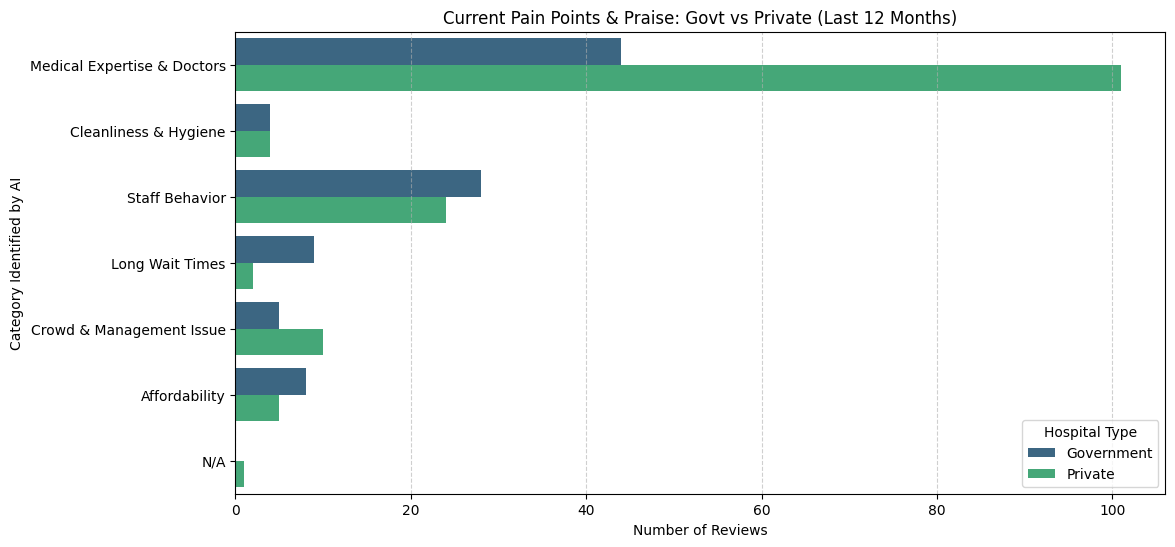

In [25]:
#Visualize pain point
plt.figure(figsize = (12,6))
order = df_plot['AI_Insight'].value_counts().index
sns.countplot(data=df_recent,y='AI_Insight',hue="Type",palette='viridis')
plt.title("Current Pain Points & Praise: Govt vs Private (Last 12 Months)")
plt.xlabel("Number of Reviews")
plt.ylabel('Category Identified by AI')
plt.grid(axis='x',linestyle='--',alpha=0.6)
plt.legend(title="Hospital Type",loc='lower right')
plt.show()

# 🏁 Final Conclusion: Hospital Experience Insights
### Project Overview
This analysis utilizes **Natural Language Processing (NLP)** and **Zero-Shot Classification (BART Model)** to objectively compare patient experiences across 6 major Delhi hospitals (Safdarjung, AIIMS, RML vs. Max, Apollo, Fortis). By filtering for reviews from the last **12 months**, we ensure the insights reflect current administrative and medical performance.

### 🔑 Key Strategic Findings
1. **The Logistics Bottleneck (Wait Times):** - AI analysis confirms that **Government hospitals (9.2%)** face nearly **7x more** complaints regarding "Long Wait Times" compared to Private hospitals (**1.4%**). This highlights a critical need for digital queue management in public sectors.
   
2. **Staff Interaction Gap:**
   - **28.6%** of Government hospital feedback identified **Staff Behavior** as a pain point, likely driven by high patient-to-staff ratios. In contrast, Private hospitals saw this at **16.4%**.

3. **Core Public Sector Strength (Medical Trust):**
   - Despite the delays, **44.9%** of Government reviews focus on praising **Medical Expertise**. This proves that public trust in the clinical skills of doctors at Safdarjung and AIIMS remains a significant competitive advantage.

4. **The Value Proposition:**
   - Government hospitals dominate in **Affordability (8.2%)**, while Private hospitals lead in **Cleanliness** and **Infrastructure**, creating a clear market segmentation based on patient priorities.

### 🚀 Future Recommendations
* **Digital Transformation:** Implementing real-time appointment tracking could directly reduce the primary pain point of wait times.
* **Soft Skills Training:** Targeted intervention for frontline staff in public hospitals could bridge the satisfaction gap currently identified by the AI.